In [ ]:
#Apertura dei dati da Google Drive
#Caricamento dei file testuali per navigare nelle cartelle e prendere le immagini
file=open("./drive/MyDrive/OSCD_dataset/OSCD_dataset_images/train.txt", "r")
content = file.read()
train_set = content.strip().split(",")
print(train_set)
file.close()

file=open("./drive/MyDrive/OSCD_dataset/OSCD_dataset_images/test.txt", "r")
content = file.read()
test_set = content.strip().split(",")
print(test_set)
file.close()


file=open("./drive/MyDrive/OSCD_dataset/OSCD_dataset_images/all.txt", "r")
content = file.read()
all_locs = content.strip().split(",")
print(all_locs)
file.close()

channels = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']

['aguasclaras', 'bercy', 'bordeaux', 'nantes', 'paris', 'rennes', 'saclay_e', 'abudhabi', 'cupertino', 'pisa', 'beihai', 'hongkong', 'beirut', 'mumbai']
['brasilia', 'montpellier', 'norcia', 'rio', 'saclay_w', 'valencia', 'dubai', 'lasvegas', 'milano', 'chongqing']
['aguasclaras', 'bercy', 'bordeaux', 'nantes', 'paris', 'rennes', 'saclay_e', 'abudhabi', 'cupertino', 'pisa', 'beihai', 'hongkong', 'beirut', 'mumbai', 'brasilia', 'montpellier', 'norcia', 'rio', 'saclay_w', 'valencia', 'dubai', 'lasvegas', 'milano', 'chongqing']


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from math import floor, ceil, sqrt, exp

import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image


class RandomNoise():
  def __call__(self,sample):
    I1, I2, label = sample['I1'], sample['I2'], sample['label']
    # Genera rumore salt and pepper
    prob = 0.1  # Probabilità di avere pixel rumorosi
    noise = np.random.choice([0, 1], size=I1.shape[1:], p=[1 - prob, prob])
    
    # Applica il rumore salt and pepper all'immagine
    I1 = torch.from_numpy((I1.numpy() * (1 - noise) + noise))
    I2 = torch.from_numpy((I2.numpy() * (1 - noise) + noise))
    return {'I1': I1, 'I2': I2, 'label': label}

class RandomFlip():
    """Flip randomly the images in a sample."""

#     def __init__(self):
#         return

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']
        
        if random.random() > 0.5:
            I1 =  I1.numpy()[:,:,::-1].copy()
            I1 = torch.from_numpy(I1)
            I2 =  I2.numpy()[:,:,::-1].copy()
            I2 = torch.from_numpy(I2)
            label =  label.numpy()[:,::-1].copy()
            label = torch.from_numpy(label)

        return {'I1': I1, 'I2': I2, 'label': label}



class RandomRot():
    """Rotate randomly the images in a sample."""

#     def __init__(self):
#         return

    def __call__(self, sample):
        I1, I2, label = sample['I1'], sample['I2'], sample['label']
        
        n = random.randint(0, 3)
        if n:
            I1 =  sample['I1'].numpy()
            I1 = np.rot90(I1, n, axes=(1, 2)).copy()
            I1 = torch.from_numpy(I1)
            I2 =  sample['I2'].numpy()
            I2 = np.rot90(I2, n, axes=(1, 2)).copy()
            I2 = torch.from_numpy(I2)
            label =  sample['label'].numpy()
            label = np.rot90(label, n, axes=(0, 1)).copy()
            label = torch.from_numpy(label)

        return {'I1': I1, 'I2': I2, 'label': label}


transform=transforms.Compose([
    # your code here
    RandomFlip(),
    RandomRot(),
    RandomNoise()
])


#Inizilizzazione del dataset
class OSCD_dataset(torch.utils.data.Dataset):
    def __init__(self, train=True, normalize=True, transform=None, patch_side = 96, stride = None):
        self.train=train
        self.transform=transform
        self.normalize=normalize
        self.patch_side=patch_side
        self.stride=1
        if stride:
          self.stride=stride
        #parametro utilizzato da quelli del paper per
        #aumentare il peso dei changed pixel.
        #potrebbe essere utile farne il tuning (?)
       
        #self.CIBW=10
       
        #Carica i dati dai file
        self.load_data()

    def __len__(self):
        # Restituisci la lunghezza del dataset
        return self.n_patches

    def __getitem__(self, idx):
        current_patch_coords = self.patch_coords[idx]
        loc = current_patch_coords[0]
        limits = current_patch_coords[1]

        I1 = self.imgs_1[loc][:, limits[0]:limits[1], limits[2]:limits[3]]
        I2 = self.imgs_2[loc][:, limits[0]:limits[1], limits[2]:limits[3]]
        label = self.change_maps[loc][limits[0]:limits[1], limits[2]:limits[3]]
      

        I1 = torch.from_numpy(I1)
        I2 = torch.from_numpy(I2)
        label = torch.from_numpy(label).float()

        sample = {'I1': I1, 'I2': I2, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    def get_img(self, loc):
       return self.imgs_1[loc], self.imgs_2[loc], self.change_maps[loc]


    def load_data(self):
      #selezione del sottoinsieme richiesto
      
        if self.train:
          self.req_set=train_set
        else:
          self.req_set=test_set
        all_data = []  # Lista per memorizzare tutti i dati da tutti i file
        all_imgs = []

        #per le patches: dal paper
        self.imgs_1 = {}
        self.imgs_2 = {}
        self.change_maps = {}
        self.n_patches_per_image = {}
        self.n_patches = 0
        self.patch_coords = []
        #per i pesi change/no-change  
        n_pix = 0
        true_pix = 0

        for loc in self.req_set:
            print('loading:', loc)
            img1_list = []
            img2_list = []

            for channel in channels:
                #prendo le immagini di ogni canale e le metto in una lista
                ch = Image.open('./drive/MyDrive/OSCD_dataset/OSCD_dataset_images/' + loc + '/imgs_1_rect/' + channel + '.tif')
                img1_list.append(np.array(ch))
                ch = Image.open('./drive/MyDrive/OSCD_dataset/OSCD_dataset_images/' + loc + '/imgs_2_rect/' + channel + '.tif')
                img2_list.append(np.array(ch))    
            if self.train:
                #carico l'immagine della ground truth
                gt = Image.open('./drive/MyDrive/OSCD_dataset/OSCD_dataset_train_labels/' + loc + '/cm/' + loc + '-cm.tif')
            else:
                gt = Image.open('./drive/MyDrive/OSCD_dataset/OSCD_dataset_test_labels/' + loc + '/cm/' + loc + '-cm.tif')
            #la ground truth ha pixel 1 (no change) e 2 (change)
            #gt = np.array(gt).reshape(gt.size[0],gt.size[1]) 
            gt=np.array(gt)-1
            '''
            print(gt.shape)
            plt.imshow(gt)
            plt.show()
            '''
            #reshape dell'immagine alle dimensioni HxWxC
            img1=np.array(img1_list).transpose((1,2,0))
            img2=np.array(img2_list).transpose((1,2,0))
            #print(img1.shape)
            if self.normalize:
                           
              img1=(img1-img1.mean(axis=(0,1)))/img1.std(axis=(0,1))
              img2=(img2-img2.mean(axis=(0,1)))/img2.std(axis=(0,1))


            #immagine diventa CxHxW come il tensore che la conterrà
            img1=img1.transpose(2,0,1)
            img2=img2.transpose(2,0,1)
    
            # load and store each image
            
            self.imgs_1[loc] = img1
            self.imgs_2[loc] = img2
            self.change_maps[loc] = gt
            
            s = gt.shape
            n_pix += np.prod(s)
            true_pix += gt.sum()
            
            # calculate the number of patches
            s = img1.shape
            #print(img1.shape)
            n1 = ceil((s[1] - self.patch_side + 1) / self.stride)
            n2 = ceil((s[2] - self.patch_side + 1) / self.stride)
            n_patches_i = n1 * n2
            #print(n_patches_i)
            self.n_patches_per_image[loc] = n_patches_i
            self.n_patches += n_patches_i
            
            #print(gt.shape)
            #print(img1.shape)

            # generate path coordinates
            for i in range(n1):
                for j in range(n2):
                    # coordinates in (x1, x2, y1, y2)
                    current_patch_coords = (loc, 
                                    [self.stride*i, self.stride*i + self.patch_side, self.stride*j, self.stride*j + self.patch_side])
                    self.patch_coords.append(current_patch_coords)

        #self.weights = [ self.CIBW * 2 * true_pix / n_pix, 2 * (n_pix - true_pix) / n_pix]
        #RIDEFINIZIONE PESI
        self.weights = np.array([ 1 , (n_pix - true_pix) / true_pix])
        self.weights = 2 * self.weights/self.weights.sum()
        return 


patch_side=96

train_set_imgs=OSCD_dataset(train=True,transform=transform,stride=(int)(patch_side/2) - 1)
test_set_imgs=OSCD_dataset(train=False)

train_loader = DataLoader(train_set_imgs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set_imgs, batch_size=32, shuffle=True)

loading: aguasclaras
loading: bercy
loading: bordeaux
loading: nantes
loading: paris
loading: rennes
loading: saclay_e
loading: abudhabi
loading: cupertino
loading: pisa
loading: beihai
loading: hongkong
loading: beirut
loading: mumbai
loading: brasilia
loading: montpellier
loading: norcia
loading: rio
loading: saclay_w
loading: valencia
loading: dubai
loading: lasvegas
loading: milano
loading: chongqing


In [ ]:
IS_PROTOTYPE = False


N_EPOCHS = 10

LOAD_TRAINED = False

print('DEFINITIONS OK')

DEFINITIONS OK


In [ ]:
# Imports
from torch.autograd import Variable

'''
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tr
'''
'''
# Models
from unet import Unet
from siamunet_conc import SiamUnet_conc
from siamunet_diff import SiamUnet_diff
from fresunet import FresUNet
'''
'''
# Other
import os
import numpy as np
import random
from skimage import io
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm as tqdm
from pandas import read_csv
from math import floor, ceil, sqrt, exp
import time
from itertools import chain
import warnings
from pprint import pprint
'''
import time
from IPython import display


print('IMPORTS OK')

IMPORTS OK


In [ ]:
# Rodrigo Caye Daudt
# https://rcdaudt.github.io/
# Daudt, R. C., Le Saux, B., & Boulch, A. "Fully convolutional siamese networks for change detection". In 2018 25th IEEE International Conference on Image Processing (ICIP) (pp. 4063-4067). IEEE.

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.padding import ReplicationPad2d

class Unet(nn.Module):
    """EF segmentation network."""

    def __init__(self, input_nbr, label_nbr):
        super(Unet, self).__init__()

        self.input_nbr = input_nbr

        self.conv11 = nn.Conv2d(input_nbr, 16, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(16)
        self.do11 = nn.Dropout2d(p=0.2)
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(16)
        self.do12 = nn.Dropout2d(p=0.2)

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(32)
        self.do21 = nn.Dropout2d(p=0.2)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(32)
        self.do22 = nn.Dropout2d(p=0.2)

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(64)
        self.do31 = nn.Dropout2d(p=0.2)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(64)
        self.do32 = nn.Dropout2d(p=0.2)
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(64)
        self.do33 = nn.Dropout2d(p=0.2)

        self.conv41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(128)
        self.do41 = nn.Dropout2d(p=0.2)
        self.conv42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(128)
        self.do42 = nn.Dropout2d(p=0.2)
        self.conv43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(128)
        self.do43 = nn.Dropout2d(p=0.2)


        self.upconv4 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv43d = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(128)
        self.do43d = nn.Dropout2d(p=0.2)
        self.conv42d = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(128)
        self.do42d = nn.Dropout2d(p=0.2)
        self.conv41d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(64)
        self.do41d = nn.Dropout2d(p=0.2)

        self.upconv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv33d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(64)
        self.do33d = nn.Dropout2d(p=0.2)
        self.conv32d = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(64)
        self.do32d = nn.Dropout2d(p=0.2)
        self.conv31d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(32)
        self.do31d = nn.Dropout2d(p=0.2)

        self.upconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(32)
        self.do22d = nn.Dropout2d(p=0.2)
        self.conv21d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(16)
        self.do21d = nn.Dropout2d(p=0.2)

        self.upconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv12d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(16)
        self.do12d = nn.Dropout2d(p=0.2)
        self.conv11d = nn.ConvTranspose2d(16, label_nbr, kernel_size=3, padding=1)

        self.sm = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):

        x = torch.cat((x1, x2), 1)

        """Forward method."""
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x))))
        x12 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12, kernel_size=2, stride=2)

        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43, kernel_size=2, stride=2)


        # Stage 4d
        x4d = self.upconv4(x4p)
        pad4 = ReplicationPad2d((0, x43.size(3) - x4d.size(3), 0, x43.size(2) - x4d.size(2)))
        x4d = torch.cat((pad4(x4d), x43), 1)
        x43d = self.do43d(F.relu(self.bn43d(self.conv43d(x4d))))
        x42d = self.do42d(F.relu(self.bn42d(self.conv42d(x43d))))
        x41d = self.do41d(F.relu(self.bn41d(self.conv41d(x42d))))

        # Stage 3d
        x3d = self.upconv3(x41d)
        pad3 = ReplicationPad2d((0, x33.size(3) - x3d.size(3), 0, x33.size(2) - x3d.size(2)))
        x3d = torch.cat((pad3(x3d), x33), 1)
        x33d = self.do33d(F.relu(self.bn33d(self.conv33d(x3d))))
        x32d = self.do32d(F.relu(self.bn32d(self.conv32d(x33d))))
        x31d = self.do31d(F.relu(self.bn31d(self.conv31d(x32d))))

        # Stage 2d
        x2d = self.upconv2(x31d)
        pad2 = ReplicationPad2d((0, x22.size(3) - x2d.size(3), 0, x22.size(2) - x2d.size(2)))
        x2d = torch.cat((pad2(x2d), x22), 1)
        x22d = self.do22d(F.relu(self.bn22d(self.conv22d(x2d))))
        x21d = self.do21d(F.relu(self.bn21d(self.conv21d(x22d))))

        # Stage 1d
        x1d = self.upconv1(x21d)
        pad1 = ReplicationPad2d((0, x12.size(3) - x1d.size(3), 0, x12.size(2) - x1d.size(2)))
        x1d = torch.cat((pad1(x1d), x12), 1)
        x12d = self.do12d(F.relu(self.bn12d(self.conv12d(x1d))))
        x11d = self.conv11d(x12d)

        return self.sm(x11d)

net, net_name = Unet(2*13, 2), 'FC-EF'


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_parameters(net))



Number of trainable parameters: 1353458


In [ ]:

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.0.1+cu118  Device: cpu


In [ ]:
weights = torch.FloatTensor(train_set_imgs.weights).to(device)
print(weights)
criterion = nn.CrossEntropyLoss(weight=weights).to(device) # to be used with logsoftmax output
net.to(device)

tensor([0.4578, 1.9542])


Unet(
  (conv11): Conv2d(26, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do11): Dropout2d(p=0.2, inplace=False)
  (conv12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do12): Dropout2d(p=0.2, inplace=False)
  (conv21): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn21): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do21): Dropout2d(p=0.2, inplace=False)
  (conv22): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn22): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do22): Dropout2d(p=0.2, inplace=False)
  (conv31): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn31): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

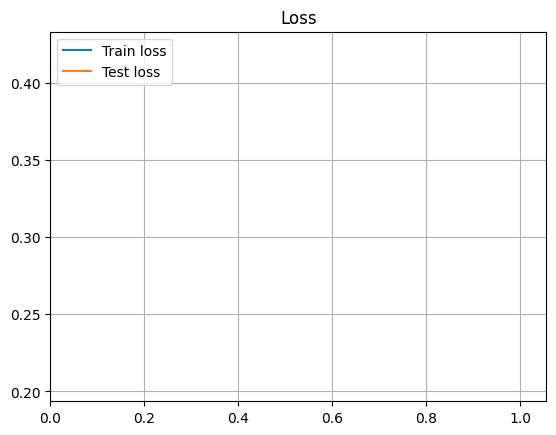

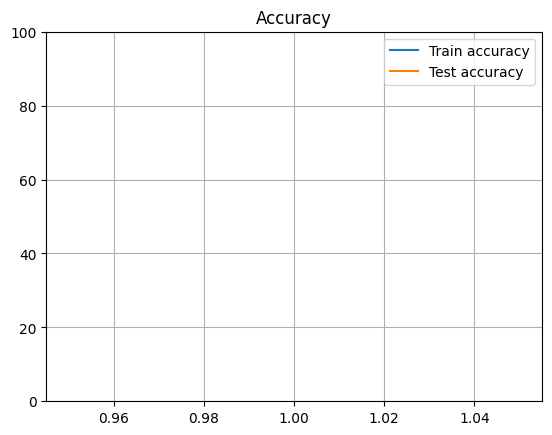

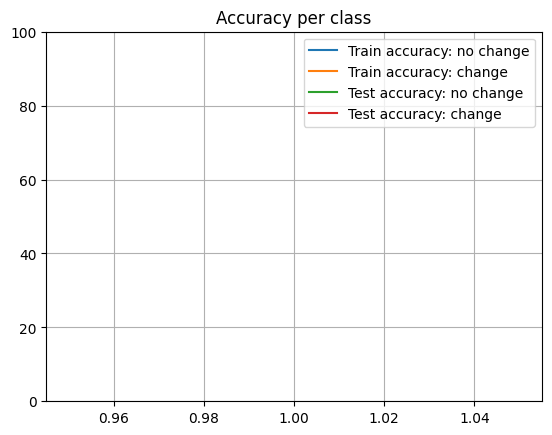

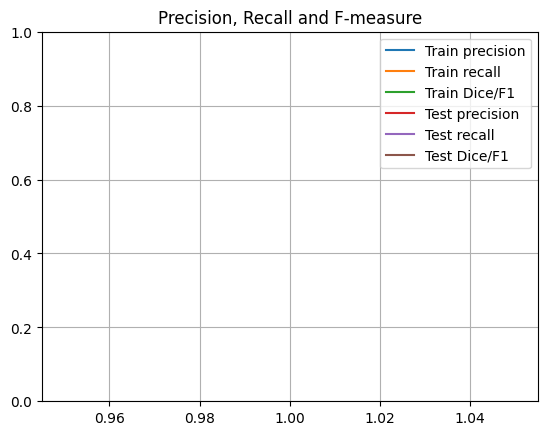

Epoch: 2 of 10


KeyboardInterrupt: ignored

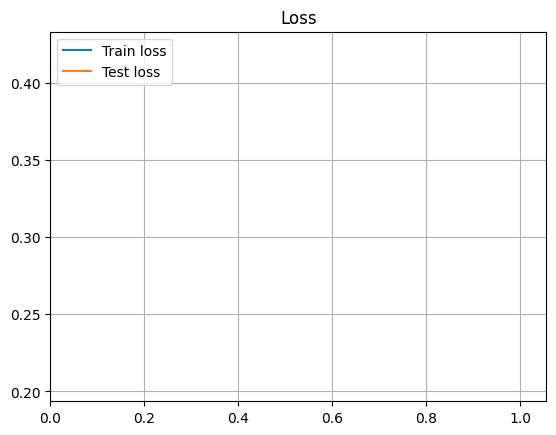

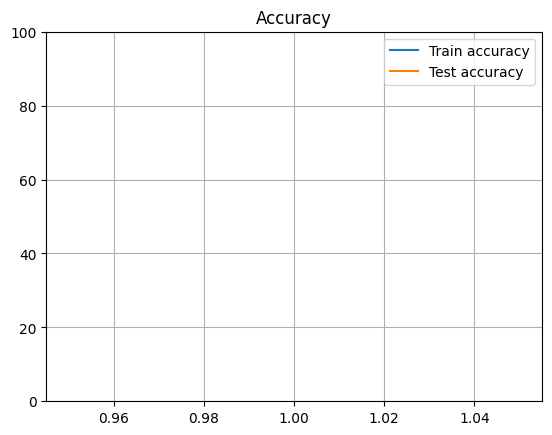

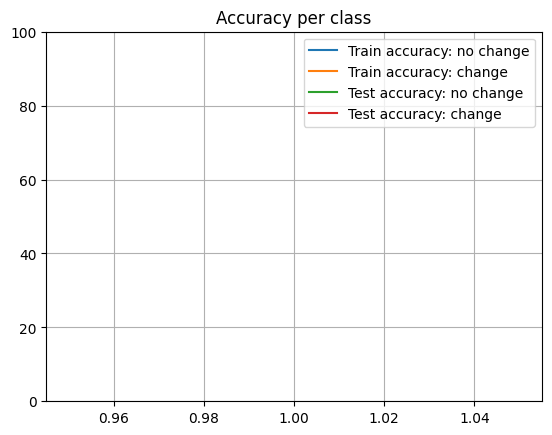

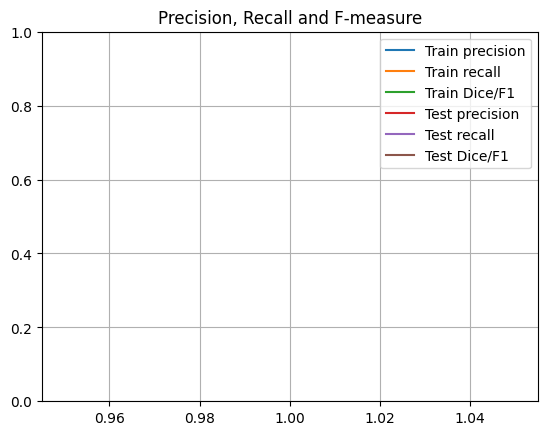

In [ ]:
def train(n_epochs = 10, save = True):
    t = np.linspace(1, n_epochs, n_epochs)
    
    epoch_train_loss = 0 * t
    epoch_train_accuracy = 0 * t
    epoch_train_change_accuracy = 0 * t
    epoch_train_nochange_accuracy = 0 * t
    epoch_train_precision = 0 * t
    epoch_train_recall = 0 * t
    epoch_train_Fmeasure = 0 * t
    epoch_test_loss = 0 * t
    epoch_test_accuracy = 0 * t
    epoch_test_change_accuracy = 0 * t
    epoch_test_nochange_accuracy = 0 * t
    epoch_test_precision = 0 * t
    epoch_test_recall = 0 * t
    epoch_test_Fmeasure = 0 * t
    
#     mean_acc = 0
#     best_mean_acc = 0
    fm = 0
    best_fm = 0
    
    lss = 1000
    best_lss = 1000
    
    plt.figure(num=1)
    plt.figure(num=2)
    plt.figure(num=3)
    
    
    optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-4)
#     optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)
        
    
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
    
    
    for epoch_index in range(N_EPOCHS):
        net.train()
        print('Epoch: ' + str(epoch_index + 1) + ' of ' + str(N_EPOCHS))

        tot_count = 0
        tot_loss = 0
        tot_accurate = 0
        class_correct = list(0. for i in range(2))
        class_total = list(0. for i in range(2))
#         for batch_index, batch in enumerate(tqdm(data_loader)):
        for batch in train_loader:
            I1 = Variable(batch['I1'].float()).to(device)
            I2 = Variable(batch['I2'].float()).to(device)
            label = Variable(batch['label']).to(device)

            optimizer.zero_grad()
            output = net(I1, I2)
            loss = criterion(output, label.long())
            loss.backward()
            optimizer.step()
            
        scheduler.step()


        epoch_train_loss[epoch_index], epoch_train_accuracy[epoch_index], cl_acc, pr_rec = test(train_set_imgs)
        epoch_train_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_train_change_accuracy[epoch_index] = cl_acc[1]
        epoch_train_precision[epoch_index] = pr_rec[0]
        epoch_train_recall[epoch_index] = pr_rec[1]
        epoch_train_Fmeasure[epoch_index] = pr_rec[2]
        
#         epoch_test_loss[epoch_index], epoch_test_accuracy[epoch_index], cl_acc, pr_rec = test(test_dataset)
        epoch_test_loss[epoch_index], epoch_test_accuracy[epoch_index], cl_acc, pr_rec = test(test_set_imgs)
        epoch_test_nochange_accuracy[epoch_index] = cl_acc[0]
        epoch_test_change_accuracy[epoch_index] = cl_acc[1]
        epoch_test_precision[epoch_index] = pr_rec[0]
        epoch_test_recall[epoch_index] = pr_rec[1]
        epoch_test_Fmeasure[epoch_index] = pr_rec[2]

        plt.figure(num=1)
        plt.clf()
        l1_1, = plt.plot(t[:epoch_index + 1], epoch_train_loss[:epoch_index + 1], label='Train loss')
        l1_2, = plt.plot(t[:epoch_index + 1], epoch_test_loss[:epoch_index + 1], label='Test loss')
        plt.legend(handles=[l1_1, l1_2])
        plt.grid()
#         plt.gcf().gca().set_ylim(bottom = 0)
        plt.gcf().gca().set_xlim(left = 0)
        plt.title('Loss')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        plt.figure(num=2)
        plt.clf()
        l2_1, = plt.plot(t[:epoch_index + 1], epoch_train_accuracy[:epoch_index + 1], label='Train accuracy')
        l2_2, = plt.plot(t[:epoch_index + 1], epoch_test_accuracy[:epoch_index + 1], label='Test accuracy')
        plt.legend(handles=[l2_1, l2_2])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Accuracy')
        display.display(plt.gcf())

        plt.figure(num=3)
        plt.clf()
        l3_1, = plt.plot(t[:epoch_index + 1], epoch_train_nochange_accuracy[:epoch_index + 1], label='Train accuracy: no change')
        l3_2, = plt.plot(t[:epoch_index + 1], epoch_train_change_accuracy[:epoch_index + 1], label='Train accuracy: change')
        l3_3, = plt.plot(t[:epoch_index + 1], epoch_test_nochange_accuracy[:epoch_index + 1], label='Test accuracy: no change')
        l3_4, = plt.plot(t[:epoch_index + 1], epoch_test_change_accuracy[:epoch_index + 1], label='Test accuracy: change')
        plt.legend(handles=[l3_1, l3_2, l3_3, l3_4])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 100)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Accuracy per class')
        display.display(plt.gcf())

        plt.figure(num=4)
        plt.clf()
        l4_1, = plt.plot(t[:epoch_index + 1], epoch_train_precision[:epoch_index + 1], label='Train precision')
        l4_2, = plt.plot(t[:epoch_index + 1], epoch_train_recall[:epoch_index + 1], label='Train recall')
        l4_3, = plt.plot(t[:epoch_index + 1], epoch_train_Fmeasure[:epoch_index + 1], label='Train Dice/F1')
        l4_4, = plt.plot(t[:epoch_index + 1], epoch_test_precision[:epoch_index + 1], label='Test precision')
        l4_5, = plt.plot(t[:epoch_index + 1], epoch_test_recall[:epoch_index + 1], label='Test recall')
        l4_6, = plt.plot(t[:epoch_index + 1], epoch_test_Fmeasure[:epoch_index + 1], label='Test Dice/F1')
        plt.legend(handles=[l4_1, l4_2, l4_3, l4_4, l4_5, l4_6])
        plt.grid()
        plt.gcf().gca().set_ylim(0, 1)
#         plt.gcf().gca().set_ylim(bottom = 0)
#         plt.gcf().gca().set_xlim(left = 0)
        plt.title('Precision, Recall and F-measure')
        display.display(plt.gcf())
        
        
#         mean_acc = (epoch_test_nochange_accuracy[epoch_index] + epoch_test_change_accuracy[epoch_index])/2
#         if mean_acc > best_mean_acc:
#             best_mean_acc = mean_acc
#             save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_acc-' + str(mean_acc) + '.pth.tar'
#             torch.save(net.state_dict(), save_str)
        
        
#         fm = pr_rec[2]
        fm = epoch_train_Fmeasure[epoch_index]
        if fm > best_fm:
            best_fm = fm
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_fm-' + str(fm) + '.pth.tar'
            torch.save(net.state_dict(), save_str)
        
        lss = epoch_train_loss[epoch_index]
        if lss < best_lss:
            best_lss = lss
            save_str = 'net-best_epoch-' + str(epoch_index + 1) + '_loss-' + str(lss) + '.pth.tar'
            torch.save(net.state_dict(), save_str)
            
            
#         print('Epoch loss: ' + str(tot_loss/tot_count))
        if save:
            im_format = 'png'
    #         im_format = 'eps'

            plt.figure(num=1)
            plt.savefig(net_name + '-01-loss.' + im_format)

            plt.figure(num=2)
            plt.savefig(net_name + '-02-accuracy.' + im_format)

            plt.figure(num=3)
            plt.savefig(net_name + '-03-accuracy-per-class.' + im_format)

            plt.figure(num=4)
            plt.savefig(net_name + '-04-prec-rec-fmeas.' + im_format)
        
    out = {'train_loss': epoch_train_loss[-1],
           'train_accuracy': epoch_train_accuracy[-1],
           'train_nochange_accuracy': epoch_train_nochange_accuracy[-1],
           'train_change_accuracy': epoch_train_change_accuracy[-1],
           'test_loss': epoch_test_loss[-1],
           'test_accuracy': epoch_test_accuracy[-1],
           'test_nochange_accuracy': epoch_test_nochange_accuracy[-1],
           'test_change_accuracy': epoch_test_change_accuracy[-1]}
    
    print('pr_c, rec_c, f_meas, pr_nc, rec_nc')
    print(pr_rec)
    
    return out

L = 1024
N = 2

def test(dset):

    net.eval()
    tot_loss = 0
    tot_count = 0
    tot_accurate = 0
    
    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    if dset.train:
      req_set=train_set
    else:
      req_set=test_set

    for img_index in req_set:
        I1_full, I2_full, cm_full = dset.get_img(img_index)
        
        s = cm_full.shape

        # Crea un'immagine RGB bianca delle stesse dimensioni dell'immagine di input
        result_image = np.zeros((s[0], s[1], 3), dtype=np.uint8) 

       
        print(img_index)
        
        steps0 = np.arange(0,s[0],ceil(s[0]/N))
        steps1 = np.arange(0,s[1],ceil(s[1]/N))
        for ii in range(N):
            for jj in range(N):
                xmin = steps0[ii]
                if ii == N-1:
                    xmax = s[0]
                else:
                    xmax = steps0[ii+1]
                ymin = steps1[jj]
                if jj == N-1:
                    ymax = s[1]
                else:
                    ymax = steps1[jj+1]
                I1 = I1_full[:, xmin:xmax, ymin:ymax]
                I2 = I2_full[:, xmin:xmax, ymin:ymax]
                cm = cm_full[xmin:xmax, ymin:ymax]

                #print(cm_full.shape)

                I1=torch.from_numpy(I1)
                I2=torch.from_numpy(I2)

                I1 = Variable(torch.unsqueeze(I1, 0).float()).to(device)
                I2 = Variable(torch.unsqueeze(I2, 0).float()).to(device)
                cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).float()).to(device)


                output = net(I1, I2)
                loss = criterion(output, cm.long())
        #         print(loss)
                tot_loss += loss.data * np.prod(cm.size())
                tot_count += np.prod(cm.size())

                _, predicted = torch.max(output.data, 1)

                c = (predicted.int() == cm.data.int())
                for i in range(c.size(1)):
                    for j in range(c.size(2)):
                        l = int(cm.data[0, i, j])
                        class_correct[l] += c[0, i, j]
                        class_total[l] += 1
   
                pr = (predicted.int() > 0).cpu().numpy()
                gt = (cm.data.int() > 0).cpu().numpy()
                
                #print(pr.shape)
                #print(cm.shape)
                #print(xmin,xmax,ymin,ymax)
                # Colora l'immagine risultato in base alla predizione

                pr=pr[0]
                gt=gt[0]

                pr_and_gt=np.logical_and(pr, gt)
                not_pr_and_not_gt=np.logical_and(np.logical_not(pr), np.logical_not(gt))
                pr_and_not_gt=np.logical_and(pr, np.logical_not(gt))
                not_pr_and_gt=np.logical_and(np.logical_not(pr), gt)
                
                tp += pr_and_gt.sum()
                tn += not_pr_and_not_gt.sum()
                fp +=pr_and_not_gt.sum()
                fn += not_pr_and_gt.sum()
                
              
                result_image[xmin:xmax,ymin:ymax][pr_and_gt] = [255, 255, 255]
                result_image[xmin:xmax,ymin:ymax][not_pr_and_not_gt] = [0, 0, 0]
                result_image[xmin:xmax,ymin:ymax][pr_and_not_gt] = [255, 0, 0]
                result_image[xmin:xmax,ymin:ymax][not_pr_and_gt] = [0, 255, 0]
                
        # Mostra l'immagine risultato
        result_image = Image.fromarray(result_image)
        result_image.show()
        result_image.save(img_index+'.png')

    net_loss = tot_loss/tot_count
    net_accuracy = 100 * (tp + tn)/tot_count
    
    for i in range(n):
        class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f_meas = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)
    rec_nc = tn / (tn + fp)
    
    pr_rec = [prec, rec, f_meas, prec_nc, rec_nc]
        
    return net_loss, net_accuracy, class_accuracy, pr_rec
    
    
if LOAD_TRAINED:
    net.load_state_dict(torch.load('net_final.pth.tar'))
    print('LOAD OK')
else:
    t_start = time.time()
    out_dic = train()
    t_end = time.time()
    print(out_dic)
    print('Elapsed time:')
    print(t_end - t_start)
    
from google.colab import files

for loc in all_locs:
  files.download(loc+'.png')
  
files.download('FC-EF-01-loss.png')
files.download('FC-EF-02-accuracy.png')
files.download('FC-EF-03-accuracy-per-class.png')
files.download('FC-EF-04-prec-rec-fmeas.png')


In [ ]:

for loc in all_locs:
  files.download(loc+'.png')
  
files.download('FC-EF-01-loss.png')
files.download('FC-EF-02-accuracy.png')
files.download('FC-EF-03-accuracy-per-class.png')
files.download('FC-EF-04-prec-rec-fmeas.png')